# Libs

In [ ]:
import csv
import math
import os
import numpy as np
#based on: https://towardsdatascience.com/decision-trees-for-classification-id3-algorithm-explained-89df76e72df1

# Working with data

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials
def loadGsheet(name):
    gc = gspread.authorize(GoogleCredentials.get_application_default())

    worksheet = gc.open(name).sheet1

    # get_all_values gives a list of rows.
    rows =  worksheet.get_all_values()
    headers = rows[0]
    cols = []
    data = {}
    for i in range(len(headers)):
            col = []
            for row in rows[1:]:
                col.append(row[i])
            cols.append(col)
            data.update({headers[i]:col})
    return data

In [ ]:
def load_csv(filename):
    fpath = os.path.join(os.getcwd(), filename)
    fs = csv.reader(open(fpath, newline='\n'))
    all_row = []
    for r in fs:
        all_row.append(r)
    headers = all_row[0]
    cols = []
    data = {}
    for i in range(len(headers)):
        col = []
        for row in all_row[1:]:
            col.append(row[i])
        cols.append(col)
        data.update({headers[i]:col})
    return data

In [ ]:
def getUnique(arr):
    list_of_uniques = []
    uniques = set(arr)
    for u in uniques:
        list_of_uniques.append(u)
    return list_of_uniques

In [ ]:
def getValueCounts(arr):
    Uniques = getUnique(arr)
    ValueCounts = {}
    for unique in Uniques:
        num = 0
        for i in range(len(arr)):
            if arr[i] == unique:
                num = num +1
        ValueCounts.update({unique:num})
    return ValueCounts

In [ ]:
!gdown https://drive.google.com/uc?id={"1xUNqLp4TlDOEp7KmpqN9OrJrwE23mLog"} #stiahnutie súboru golf-dataset.csv"
filename = "./golf-dataset.csv"

Downloading...
From: https://drive.google.com/uc?id=1xUNqLp4TlDOEp7KmpqN9OrJrwE23mLog
To: /content/golf-dataset.csv
100% 412/412 [00:00<00:00, 819kB/s]


In [ ]:
filename = "/content/drive/MyDrive/ML/golf-dataset.csv"

In [ ]:
data = load_csv(filename)

In [ ]:
data = loadGsheet("golf-dataset") #https://docs.google.com/spreadsheets/d/111wSlLYTpZxdoa-IoTPPgjw5GwyhhbcPqgFpSdOfx2U/edit?usp=sharing

In [ ]:
import pandas as pd
pd.DataFrame.from_records(data)

,Humidity,Outlook,Play Golf,Temp,Windy
0,High,Rainy,Yes,Hot,FALSE
1,High,Rainy,Yes,Hot,TRUE
2,High,Overcast,Yes,Hot,FALSE
3,High,Sunny,Yes,Mild,FALSE
4,Normal,Sunny,Yes,Cool,FALSE
5,Normal,Sunny,No,Cool,TRUE
6,Normal,Overcast,Yes,Cool,TRUE
7,High,Rainy,No,Mild,FALSE
8,Normal,Rainy,Yes,Cool,FALSE
9,Normal,Sunny,Yes,Mild,FALSE


# Algorithm

## Entropy of space

>$H\left(S\right)=\sum\limits_{x\:∈\:X}\:-p\left(x\right)\log _2p\left(x\right)$


*   S – The current dataset for which entropy is being calculated 
*   X – The set of classes in S
*   p(x) – The proportion of the number of elements in class x to the number of elements in set S



In [ ]:
def log2(num):
    return (math.log(num,2) if num != 0 else 0)

In [ ]:
def find_entropy(data):
    Class = list(data.keys())[-1] # hlavný atribút s triedamy
    entropy = 0 # na zažiatku je entropia 0
    values = getUnique(data[Class]) # jednotlivé triedy
    for value in values: # iterácia cez počet tried
        fraction =getValueCounts(data[Class])[value]/len(data[Class]) # akú časť z celku tvorí daná trieda
        entropy += -fraction*log2(fraction) #výpočet entropie podla vzorca dole
    return entropy

## Entropy of atribute
> $H\left(S,atrib\right)=\sum\limits_{i} \:p\left(atrib_i\right)\cdot H\left(atrib_i\right)$



In [ ]:
def getNum(atribArr,variable,classArr,target_variable):
    counter = 0
    for i in range(0,len(atribArr)):
        if atribArr[i] == variable and classArr[i] == target_variable:
            counter = counter + 1
    return counter

def getDen(atribArr,variable):
    counter = 0
    for i in range(len(atribArr)):
        if atribArr[i] == variable:
            counter = counter + 1
    return counter
def find_entropy_attribute(df,attribute):# výpočet entropie atribútu
  Class = list(df.keys())[-1]   # hlavný atribút s triedamy
  target_variables = getUnique(df[Class])  # jednotlivé triedy
  variables = getUnique(df[attribute])    # jednotlivé možnosti v atribútoch
  entropy2 = 0 # na zažiatku je entropia atributu 0
  for variable in variables: #iterácia cez možnosti atribútov
      entropy = 0 # na začiatku je entropia jednej z možnosti atributov 0
      for target_variable in target_variables:#iterácia cez počet tried
          num = getNum(df[attribute],variable,df[Class],target_variable)# počet prípadov jednej možnosti atributov, ktoré sa rovnajú danej triede v iterácii 
          den = getDen(df[attribute],variable)#  počet prípadov jednej možnosti atributov
          fraction = num/(den) # podiel počet prípadov danej možnosti atributov
          entropy += -fraction*log2(fraction) #entropia jednej z možností atribútov
      fraction2 = den/len(df[Class]) # podiel jednej možnosti z atribov ku všetky možnostiam
      entropy2 += fraction2*entropy # vysledná etropia
  return entropy2

In [ ]:
def getArgmax(arr):
    Savemax = 0
    saveIndex = 0
    for index in range(len(arr)):
        if arr[index] > Savemax:
            Savemax = arr[index]
            saveIndex = index
    return saveIndex
def find_winner(df):
    Entropy_att = []
    IG = []
    for key in list(df.keys())[:-1]:
        IG.append(find_entropy(df)-find_entropy_attribute(df,key))
    return list(data.keys())[:-1][getArgmax(IG)]

##  Building Tree

In [ ]:
def getSubTable(data, atrb,value):
    newData = data.copy()
    indices = []
    for i in range(0,len(atrb)):
        if atrb[i] == value:
            indices.append(i)
    for key in data.keys():
        newData[key] = [i for j, i in enumerate(newData[key]) if j in indices]
    return newData

def fit(df,tree=None):
    Class = list(data.keys())[-1] #Triedy
    
    node = find_winner(df) #hľadanie najlepšiehp atribútu podĺa IG
    
    attValue = getUnique(df[node])
    
    #vytvorenie stromu na začiatku
    if tree is None:                    
        tree={}
        tree[node] = {}

    # vytvorenie cyklu na konštrukciu stromu volaním funkcie rekurzivne 
    for value in attValue:
        #print(value,node)
        subtable = getSubTable(df,df[node],value)

        clValue,counts = np.unique(subtable[Class],return_counts=True)                       
        
        if len(counts)==1: #ak subset obsahuje iba jednu triedu tak končíme

            tree[node][value] = clValue[0]                                                    
        else:        
            tree[node][value] = fit(subtable) # Ak nebosahuje jednu triedu tak volam funkciu rekurzívne
                   
    return tree

## Predict

In [ ]:
def predict(inst,tree):
    Class = None
    prediction = None
    #Rekurzivný prechod stromom
    for nodes in tree.keys():        
        value = inst[nodes][0]
        if value in list(tree[nodes]): 
            tree = tree[nodes][value] #ak sa hodnota nachádza vo vetve stromu, tak ju použije
        else:
            prediction = Class 
            break;
        prediction = Class
            
        if type(tree) is dict: # prechádzanie rekurzívne stromom pokiaľ je dict
            prediction = predict(inst, tree)
        else:
            prediction = tree
            break;                            
    return prediction

In [ ]:
import pydot
from graphviz import Digraph
def printTreePretty(tree,data):
    labels = getUnique(data[list(data.keys())[-1]])
    print("Target atribute classes: {}".format(labels))
    atributes = list(data.keys())[0:-1]
    print("Atributes : {}".format(atributes))

    def draw(parent_name, child_name,labels,atributes):
        for atrib in atributes:
            if str(str(parent_name)) == atrib:
                dot.node(str(parent_name),style='filled',fillcolor='#78BED4')
        for label in labels:
            if str(str(child_name)) == label:
                dot.node(str(child_name),style='filled',fillcolor="#E79576")

        dot.edge(str(parent_name),str(child_name))

    def visit(node,labels,atributes, parent=None):
        for k,v in node.items():
            if isinstance(v, dict):
                # We start with the root node whose parent is None
                # we don't want to graph the None node
                if parent:
                    draw(parent, k,labels,atributes)
                visit(v,labels,atributes, k)
            else:
                draw(parent, k,labels,atributes)
                # drawing the label using a distinct name
                draw(k, v,labels,atributes)

    #graph = pydot.Dot(graph_type='graph')
    dot = Digraph(comment='The Round Table')
    visit(tree,labels,atributes)
    #graph.write_png('example1_graph.png')
    return dot

# Testing and visualizing

Target atribute classes: ['Yes', 'No']
Atributes : ['Outlook', 'Temp', 'Humidity', 'Windy']


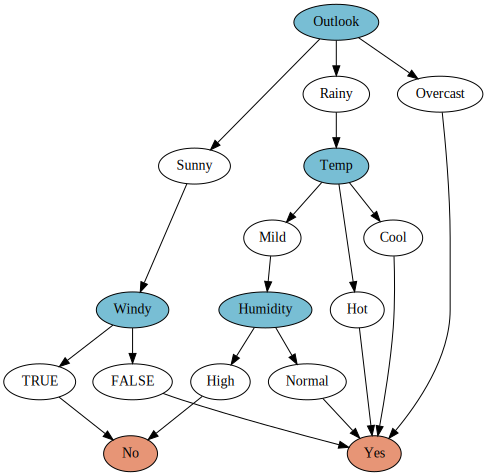

In [ ]:
tree = fit(data)
printTreePretty(tree,data)

In [ ]:
from pprint import pprint
pprint(tree)

In [ ]:
test = \
{"Outlook"  : ["Sunny"],
 "Temp"     : ["Hot"],
 "Humidity" : ["Normal"],
 "Windy"    : ["FALSE"],
 "Play Golf": ["No"]
 }
print(test)

{'Outlook': ['Sunny'], 'Temp': ['Hot'], 'Humidity': ['Normal'], 'Windy': ['FALSE'], 'Play Golf': ['No']}


In [ ]:
print(predict(test,tree))

Yes
